#Решение задачи регрессии с помощью нейронных сетей. Предсказание результата футбольного матча по результату первого тайма.

В данном проекте с помощью датасета с результатами футбольных матчей Ла Лиги (испанского футбольного чемпионата) хотим предсказать, какой будет результат футбольного матча, если у нас имеется результат первого тайма игры

# Импортирование библиотек

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, regularizers

# Предобработка данных

Чтение файла с результатами матчей ЛА Лиги

In [2]:
data = pd.read_csv('/content/drive/MyDrive/ОЖИДАЕТ ХабибуллинДР/LaLiga_Matches.csv')
data.head()

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR
0,1995-96,02-09-1995,La Coruna,Valencia,3,0,H,2.0,0.0,H
1,1995-96,02-09-1995,Sp Gijon,Albacete,3,0,H,3.0,0.0,H
2,1995-96,03-09-1995,Ath Bilbao,Santander,4,0,H,2.0,0.0,H
3,1995-96,03-09-1995,Ath Madrid,Sociedad,4,1,H,1.0,1.0,D
4,1995-96,03-09-1995,Celta,Compostela,0,1,A,0.0,0.0,D


Видим, что результаты футбольных матчей Ла Лиги представлены с сезона 1995/1996. Очевидно, что такие игры никак не помогут предсказать результат матча, так как с того времени поменялось много чего: изменились правила игры, прошло несколько поколений футболистов и много чего другого. Никак нельзя оценить готовность команды к матчу по ее играм 30-летней давности, поэтому принято решение работать с играми последних 5 лет.

In [3]:
data = data.drop(data.query("Season < '2019'").index)
data.head()

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR
9284,2019-20,16-08-2019,Ath Bilbao,Barcelona,1,0,H,0.0,0.0,D
9285,2019-20,17-08-2019,Celta,Real Madrid,1,3,A,0.0,1.0,A
9286,2019-20,17-08-2019,Valencia,Sociedad,1,1,D,0.0,0.0,D
9287,2019-20,17-08-2019,Mallorca,Eibar,2,1,H,1.0,0.0,H
9288,2019-20,17-08-2019,Leganes,Osasuna,0,1,A,0.0,0.0,D


Смотрим, сколько различных команд принимало участие в Ла Лиге с сезона 2019/2020

In [4]:
len(data['HomeTeam'].unique())

27

Смотрим, сколько матчей отыграла каждая команда с сезона 2019/2020

In [5]:
sorted_counts = (data['HomeTeam'].value_counts() + data['AwayTeam'].value_counts()).sort_values(ascending=False)
print(sorted_counts)

Villarreal     160
Ath Bilbao     160
Barcelona      160
Betis          160
Valencia       160
Celta          160
Sociedad       160
Real Madrid    160
Getafe         160
Osasuna        160
Ath Madrid     159
Sevilla        159
Mallorca       122
Alaves         122
Cadiz          122
Granada        122
Levante        114
Espanol        114
Elche          114
Valladolid     114
Vallecano       84
Eibar           76
Almeria         46
Girona          46
Huesca          38
Leganes         38
Las Palmas       8
Name: count, dtype: int64


Видим, что есть те команды, которые провели очень мало матчей в Ла Лиге с сезона 2019/2020, поэтому было принято решение оставить 20 команд для предсказания, которые отыграли достаточно большое количество матчей (хотя бы больше 100)

In [6]:
data = data.drop(data[data['HomeTeam'].isin(['Vallecano', 'Eibar', 'Almeria', 'Girona', 'Huesca', 'Leganes', 'Las Palmas'])].index)
data = data.drop(data[data['AwayTeam'].isin(['Vallecano', 'Eibar', 'Almeria', 'Girona', 'Huesca', 'Leganes', 'Las Palmas'])].index)

Также уберем столбец с результатом первого тайма (FTR), который показывает победителя первого тайма или ничью, так как больше информации нам даст количество забитых голов

In [7]:
data = data.drop('HTR', axis=1)

In [8]:
data

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG
9284,2019-20,16-08-2019,Ath Bilbao,Barcelona,1,0,H,0.0,0.0
9285,2019-20,17-08-2019,Celta,Real Madrid,1,3,A,0.0,1.0
9286,2019-20,17-08-2019,Valencia,Sociedad,1,1,D,0.0,0.0
9289,2019-20,17-08-2019,Villarreal,Granada,4,4,D,1.0,1.0
9290,2019-20,18-08-2019,Alaves,Levante,1,0,H,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10874,2023-24,30-09-2023,Getafe,Villarreal,0,0,D,0.0,0.0
10877,2023-24,30-09-2023,Sociedad,Ath Bilbao,3,0,H,1.0,0.0
10879,2023-24,01-10-2023,Alaves,Osasuna,0,2,A,0.0,1.0
10880,2023-24,01-10-2023,Ath Madrid,Cadiz,3,2,H,1.0,2.0


Получаем следующие столбцы:

1.   Season	- сезон проведения чемпионата
2.   Date	- дата матча
3.   HomeTeam - команда, которая принимает матч (на ее стадионе проходит матч между командами)
4.   AwayTeam	- команда, которая играет в гостях (на выезде)
5.   FTHG - количество голов, забитое в матче командой, играющей дома
6.   FTAG - количество голов, забитое в матче командой, играющей в гостях
7.   FTR - победитель матча
8.   HTHG	- количество голов, забитое в первом тайме командой, играющей дома
9.   HTAG	- количество голов, забитое в первом тайме командой, играющей в гостях



In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1275 entries, 9284 to 10881
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Season    1275 non-null   object 
 1   Date      1275 non-null   object 
 2   HomeTeam  1275 non-null   object 
 3   AwayTeam  1275 non-null   object 
 4   FTHG      1275 non-null   int64  
 5   FTAG      1275 non-null   int64  
 6   FTR       1275 non-null   object 
 7   HTHG      1275 non-null   float64
 8   HTAG      1275 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 131.9+ KB


In [10]:
label_encoder = LabelEncoder()

data['Season'] = label_encoder.fit_transform(data['Season'])
data['Date'] = label_encoder.fit_transform(data['Date'])
data['FTR'] = label_encoder.fit_transform(data['FTR'])
data['HomeTeam'] = label_encoder.fit_transform(data['HomeTeam'])
data['AwayTeam'] = label_encoder.fit_transform(data['AwayTeam'])
print(data)

       Season  Date  HomeTeam  AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG
9284        0   246         1         3     1     0    2   0.0   0.0
9285        0   259         6        14     1     3    0   0.0   1.0
9286        0   259        17        16     1     1    1   0.0   0.0
9289        0   259        19        10     4     4    1   1.0   1.0
9290        0   275         0        11     1     0    2   0.0   0.0
...       ...   ...       ...       ...   ...   ...  ...   ...   ...
10874       4   495         9        19     0     0    1   0.0   0.0
10877       4   495        16         1     3     0    2   1.0   0.0
10879       4    15         0        13     0     2    0   0.0   1.0
10880       4    15         2         5     3     2    2   1.0   2.0
10881       4    15         4        17     3     0    2   1.0   0.0

[1275 rows x 9 columns]


#Создание нейросети

In [42]:
train_dataset = data.sample(frac=0.85, random_state=0)
test_dataset = data.drop(train_dataset.index)
X_train = train_dataset.copy()
X_test = test_dataset.copy()
y_train = X_train.pop("FTR")
y_test = X_test.pop('FTR')

In [43]:
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = Sequential([
      normalizer,
      layers.Dense(300, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
      layers.Dropout(0.5),
      layers.Dense(1200, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
      layers.Dropout(0.5),
      layers.Dense(2500, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
      layers.Dropout(0.5),
      layers.Dense(300, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
      layers.Dense(1, activation='linear')
      ])


In [44]:
model.compile(loss='mse', optimizer = Adam(0.001), metrics=['mae'])

# Обучение нейросети

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normaliza  (None, 8)                 17        
 tion)                                                           
                                                                 
 dense_20 (Dense)            (None, 300)               2700      
                                                                 
 dropout_12 (Dropout)        (None, 300)               0         
                                                                 
 dense_21 (Dense)            (None, 1200)              361200    
                                                                 
 dropout_13 (Dropout)        (None, 1200)              0         
                                                                 
 dense_22 (Dense)            (None, 2500)              3002500   
                                                      

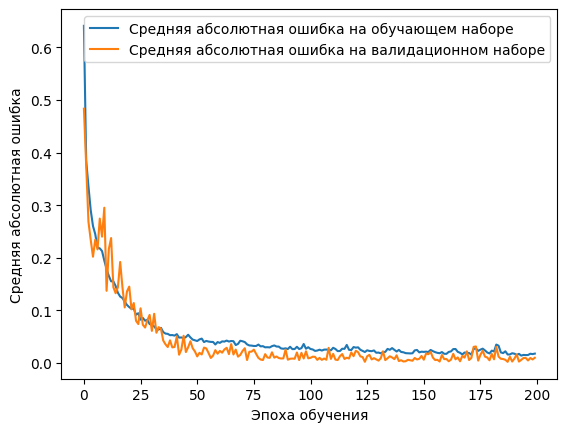

In [45]:
model.summary()

history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    verbose=1, epochs=200)

plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на валидационном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

# Результат работы нейросети на тестовой выборке

Смотрим на MAE

In [54]:
model.evaluate(X_test, y_test, verbose=0)[1]

0.008799134753644466

In [48]:
y_predict = model.predict(X_test)

6/6 [==============================] - 0s 18ms/step


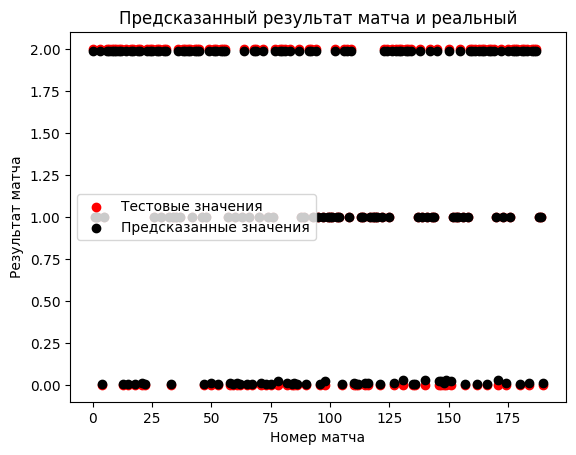

In [52]:
plt.scatter(range(len(y_test)), y_test, color="red", label="Тестовые значения")
plt.scatter(range(len(y_test)), y_predict, color="black", label="Предсказанные значения")
plt.xlabel("Номер матча")
plt.ylabel("Результат матча")
plt.title("Предсказанный результат матча и реальный")
plt.legend()
plt.show()